# Sprint13 ディープラーニングフレームワーク1

## 1.このSprintについて

### Sprintの目的
- フレームワークのコードを読めるようにする
- フレームワークを習得し続けられるようになる
- 理論を知っている範囲をフレームワークで動かす

### どのように学ぶか
TensorFLowのサンプルコードを元に、これまで扱ってきたデータセットを学習していきます。

### 2.コードリーディング
TensorFLowによって2値分類を行うサンプルコードを載せました。今回はこれをベースにして進めます。

tf.kerasやtf.estimatorなどの高レベルAPIは使用していません。低レベルなところから見ていくことにします。

### 【問題1】スクラッチを振り返る
ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。

#### （例）

- 重みを初期化する必要があった
- エポックのループが必要だった

それらがフレームワークにおいてはどのように実装されるかを今回覚えていきましょう。

### 【解答】
- ミニバッチ処理
- 重みの初期化
- 活性化関数

### データセットの用意
以前から使用しているIrisデータセットを使用します。以下のサンプルコードではIris.csvが同じ階層にある想定です。

[Iris Species](https://www.kaggle.com/uciml/iris/data)

目的変数はSpeciesですが、3種類ある中から以下の2種類のみを取り出して使用します。
- Iris-versicolor
- Iris-virginica

### 【問題2】スクラッチとTensorFlowの対応を考える
以下のサンプルコードを見て、先ほど列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認してください。

それを簡単に言葉でまとめてください。単純な一対一の対応であるとは限りません。

#### 《サンプルコード》

＊バージョン1.5から1.14の間で動作を確認済みです。

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

W1021 21:17:28.983097  5132 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 0, loss : 0.2720, val_loss : 1.2636, acc : 1.000, val_acc : 0.750
Epoch 1, loss : 12.8287, val_loss : 5.6927, acc : 0.500, val_acc : 0.688
Epoch 2, loss : 0.0000, val_loss : 0.0329, acc : 1.000, val_acc : 1.000
Epoch 3, loss : 0.0000, val_loss : 0.0002, acc : 1.000, val_acc : 1.000
Epoch 4, loss : 0.0000, val_loss : 0.0046, acc : 1.000, val_acc : 1.000
Epoch 5, loss : 0.0000, val_loss : 0.2465, acc : 1.000, val_acc : 0.938
Epoch 6, loss : 0.0026, val_loss : 2.6862, acc : 1.000, val_acc : 0.812
Epoch 7, loss : 0.0000, val_loss : 1.1610, acc : 1.000, val_acc : 0.875
Epoch 8, loss : 0.0133, val_loss : 3.9413, acc : 1.000, val_acc : 0.812
Epoch 9, loss : 0.0000, val_loss : 0.0002, acc : 1.000, val_acc : 1.000
test_acc : 0.900


### 【解答】
- tf.Variable(tf.random_normal)で重みとバイアスの初期化
- for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):でミニバッチ処理のクラスを呼び出し
- tf.nn.reluで活性化関数を通している

## 3.他のデータセットへの適用
これまで扱ってきた小さなデータセットがいくつかあります。上記サンプルコードを書き換え、これらに対して学習・推定を行うニューラルネットワークを作成してください。

- Iris（3種類全ての目的変数を使用）
- House Prices

どのデータセットもtrain, val, testの3種類に分けて使用してください。

### 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成
Irisデータセットのtrain.csvの中で、目的変数Speciesに含まれる3種類全てを分類できるモデルを作成してください。

[Iris Species](https://www.kaggle.com/uciml/iris/data)

2クラスの分類と3クラス以上の分類の違いを考慮してください。それがTensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べてください。

#### 《ヒント》

以下の2箇所は2クラス分類特有の処理です。
```
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
```

メソッドは以下のように公式ドキュメントを確認してください。

[tf.nn.sigmoid_cross_entropy_with_logits  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)

[tf.math.sign  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/math/sign)

＊tf.signとtf.math.signは同じ働きをします。

In [3]:
from sklearn.preprocessing import OneHotEncoder

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis]

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:])

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
max_Y = (tf.argmax(Y, 1))
max_Y_pred = tf.argmax(logits, 1)

correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1))

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    max_y, max_y_pred = sess.run([max_Y, max_Y_pred], feed_dict={X: X_test, Y: y_test})
    print("y_test:{}".format(max_y))
    print("y_pred:{}".format(max_y_pred))
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 55.2556, val_loss : 36.1435, acc : 0.333, val_acc : 0.708
Epoch 1, loss : 0.0018, val_loss : 11.1857, acc : 1.000, val_acc : 0.708
Epoch 2, loss : 1.5379, val_loss : 6.0970, acc : 0.833, val_acc : 0.750
Epoch 3, loss : 0.0000, val_loss : 6.4464, acc : 1.000, val_acc : 0.833
Epoch 4, loss : 0.0000, val_loss : 3.2571, acc : 1.000, val_acc : 0.875
Epoch 5, loss : 0.0000, val_loss : 3.2235, acc : 1.000, val_acc : 0.875
Epoch 6, loss : 0.0000, val_loss : 2.7380, acc : 1.000, val_acc : 0.875
Epoch 7, loss : 0.0000, val_loss : 2.3899, acc : 1.000, val_acc : 0.875
Epoch 8, loss : 0.0000, val_loss : 2.5583, acc : 1.000, val_acc : 0.875
Epoch 9, loss : 0.0000, val_loss : 3.8582, acc : 1.000, val_acc : 0.917
y_test:[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]
y_pred:[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 2 0 0 2 2 0 0 2 0 0 1 1 0]
test_acc : 0.933


### 【問題4】House Pricesのモデルを作成
回帰問題のデータセットであるHouse Pricesを使用したモデルを作成してください。

[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使ってください。説明変数はさらに増やしても構いません。

分類問題と回帰問題の違いを考慮してください。

Epoch 0, loss : 1510372.1250, val_loss : 1202257.0000
Epoch 1, loss : 764276.0625, val_loss : 707015.5000
Epoch 2, loss : 514365.5938, val_loss : 468743.2188
Epoch 3, loss : 306861.1875, val_loss : 253333.2969
Epoch 4, loss : 174360.2188, val_loss : 128231.8594
Epoch 5, loss : 114818.0391, val_loss : 82652.7109
Epoch 6, loss : 98282.6562, val_loss : 78835.7344
Epoch 7, loss : 75405.1875, val_loss : 57283.8125
Epoch 8, loss : 56685.4023, val_loss : 33066.7656
Epoch 9, loss : 44840.5000, val_loss : 19822.0586
test_mse : 44840.500


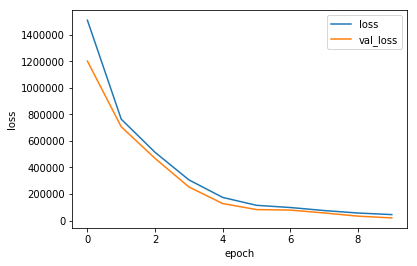

In [4]:
# データセットの読み込み
dataset_path ="train.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y = y.astype(np.int)[:, np.newaxis]
y = np.log(y)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op =  tf.losses.mean_squared_error(labels=Y, predictions=logits)
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
y_pred = logits

# variableの初期化
init = tf.global_variables_initializer()

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        # エポックごとにループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        loss = sess.run(loss_op, feed_dict={X: X_train, Y: y_train})
        loss_list.append(loss)
        val_loss = sess.run(loss_op, feed_dict={X: X_val, Y: y_val})
        val_loss_list.append(val_loss)
        
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}".format(epoch, loss, val_loss))
    print("test_mse : {:.3f}".format(loss))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss_list, label='loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.legend()
    plt.show()


### 【問題5】MNISTのモデルを作成
ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成してください。

3クラス以上の分類という点ではひとつ前のIrisと同様です。入力が画像であるという点で異なります。

スクラッチで実装したモデルの再現を目指してください。

In [5]:
from keras.datasets import mnist

Using TensorFlow backend.


In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

y_train = y_train.astype(np.int)[:, np.newaxis]
y_test = y_test.astype(np.int)[:, np.newaxis]

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:])
y_test_one_hot = enc.fit_transform(y_test[:])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
max_Y = (tf.argmax(Y, 1))
max_Y_pred = tf.argmax(logits, 1)

correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1))

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 1.5490, val_loss : 1.0970, acc : 0.500, val_acc : 0.763
Epoch 1, loss : 1.5158, val_loss : 0.9345, acc : 0.600, val_acc : 0.809
Epoch 2, loss : 0.7138, val_loss : 0.5766, acc : 0.700, val_acc : 0.884
Epoch 3, loss : 1.0118, val_loss : 0.4092, acc : 0.700, val_acc : 0.904
Epoch 4, loss : 1.1856, val_loss : 0.4444, acc : 0.600, val_acc : 0.902
Epoch 5, loss : 0.6465, val_loss : 0.3710, acc : 0.800, val_acc : 0.919
Epoch 6, loss : 0.4175, val_loss : 0.3503, acc : 0.900, val_acc : 0.920
Epoch 7, loss : 0.2887, val_loss : 0.3343, acc : 0.900, val_acc : 0.928
Epoch 8, loss : 0.8892, val_loss : 0.3812, acc : 0.800, val_acc : 0.919
Epoch 9, loss : 0.4571, val_loss : 0.4125, acc : 0.700, val_acc : 0.924
test_acc : 0.925
